# Fine Tune a Text Classifier

We are trying to fine-tune a text classifier based a transformer language model.

Basically, we are trying to train a bit more with our data. We use HF transformers module for this.

In [1]:
!pip install transformers datasets umap-learn sklearn

## The Dataset

In [2]:
from datasets import load_dataset

In [3]:
ds_emotions = load_dataset("tweet_eval", "emotion")
ds_emotions

Found cached dataset tweet_eval (/home/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})

In [4]:
ds_emotions.set_format("pandas")
ds_emotions["train"][:].head()

,text,label
0,“Worry is a down payment on a problem you may ...,2
1,My roommate: it's okay that we can't spell bec...,0
2,No but that's so cute. Atsu was probably shy a...,1
3,Rooneys fucking untouchable isn't he? Been fuc...,0
4,it's pretty depressing when u hit pan on ur fa...,3


In [5]:
ds_emotions["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['anger', 'joy', 'optimism', 'sadness'], id=None)}

## Tokenized Dataset

We need to tokeninze the text labels, that's what the tokenizer does.

In [6]:
model_name = "distilbert-base-uncased"

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer

PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [8]:
ds_emotions.reset_format()
ds_emotions["train"][0:2]["text"]

["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 "My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs"]

In [9]:
# padding these for 50 max_length characters.
tokenizer(ds_emotions["train"][0:2]["text"], padding="max_length", max_length=50, truncation=True)

{'input_ids': [[101, 1523, 4737, 2003, 1037, 2091, 7909, 2006, 1037, 3291, 2017, 2089, 2196, 2031, 1005, 1012, 11830, 11527, 1012, 1001, 14354, 1001, 4105, 1001, 4737, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2026, 18328, 1024, 2009, 1005, 1055, 3100, 2008, 2057, 2064, 1005, 1056, 6297, 2138, 2057, 2031, 8285, 27108, 2890, 6593, 1012, 1001, 6659, 1001, 2034, 11108, 21572, 5910, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

### Tokenizing the whole dataset

Here we will add both `input_ids` and `attention_mask` to the model. These are usually the inputs to our model.

In [10]:
def ds_tokenize_batch(batch):
    token_info = tokenizer(batch["text"], padding="max_length", max_length=50, truncation=True)
    return token_info

ds_emotions_encoded = ds_emotions.map(ds_tokenize_batch, batched=True, batch_size=64)

  0%|          | 0/51 [00:00<?, ?ba/s]

  0%|          | 0/23 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [11]:
ds_emotions_encoded.set_format("torch")
ds_emotions_encoded["train"][0:2]

{'text': ["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
  "My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs"],
 'label': tensor([2, 0]),
 'input_ids': tensor([[  101,  1523,  4737,  2003,  1037,  2091,  7909,  2006,  1037,  3291,
           2017,  2089,  2196,  2031,  1005,  1012, 11830, 11527,  1012,  1001,
          14354,  1001,  4105,  1001,  4737,   102,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
         [  101,  2026, 18328,  1024,  2009,  1005,  1055,  3100,  2008,  2057,
           2064,  1005,  1056,  6297,  2138,  2057,  2031,  8285, 27108,  2890,
           6593,  1012,  1001,  6659,  1001,  2034, 11108, 21572,  5910,   102,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              

## Loading the Fine Tuning Model

Now we need to a load model with the classification head

In [12]:
device="cuda"

In [13]:
import torch
from transformers import AutoModelForSequenceClassification

In [14]:
num_labels = len(ds_emotions["train"].features["label"].names)
num_labels

4

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

### Usage

In [16]:
ds_sample = ds_emotions_encoded["train"][0:10]
input_ids = ds_sample["input_ids"].to(device)
attention_mask = ds_sample["attention_mask"].to(device)
with torch.no_grad():
    result = model(input_ids=input_ids, attention_mask=attention_mask)
result

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0421,  0.0950, -0.1422,  0.0207],
        [ 0.0020,  0.1366, -0.1009,  0.0108],
        [ 0.0320,  0.0928, -0.1333,  0.0243],
        [ 0.0215,  0.1130, -0.0921,  0.0549],
        [ 0.0167,  0.0996, -0.1184,  0.0274],
        [ 0.0155,  0.1247, -0.1101,  0.0042],
        [ 0.0217,  0.0790, -0.1378,  0.0055],
        [-0.0107,  0.1339, -0.1169,  0.0548],
        [ 0.0161,  0.1063, -0.0894, -0.0305],
        [ 0.0087,  0.1065, -0.1221,  0.0144]], device='cuda:0'), hidden_states=None, attentions=None)

In [17]:
torch.argmax(result.logits, dim=1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [18]:
ds_sample["label"]

tensor([2, 0, 1, 0, 3, 0, 3, 1, 0, 0])

As you can see, what's predicted here is not that accurate. That's because this model is not fine tuned with our dataset. That's what we are going to do next.

## Fine Tuning

In [19]:
from transformers import Trainer, TrainingArguments
from transformers.trainer_utils import EvalPrediction 

In [20]:
batch_size = 64
output_model = f"{model_name}-finetuned"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

training_args = TrainingArguments(
    output_dir=output_model,
    num_train_epochs=10,
    learning_rate=0.00001,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.001,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=len(ds_emotions_encoded["train"]) // batch_size,
    log_level="error"
)

def calc_matrics(batch:EvalPrediction):
    masks = torch.tensor(batch.predictions).argmax(dim=1) == torch.tensor(batch.label_ids)
    accuracy = torch.sum(masks) / len(masks)
    return {"accuracy": accuracy}

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset=ds_emotions_encoded["train"],
    eval_dataset=ds_emotions_encoded["test"],
    tokenizer=tokenizer,
    compute_metrics=calc_matrics
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [21]:
trainer.train()

/opt/conda/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.253400,1.088703,0.571429
2,0.932500,0.778685,0.744546
3,0.702600,0.651482,0.782547
4,0.583200,0.599186,0.797326
5,0.502400,0.578342,0.799437
6,0.457100,0.571813,0.800141
7,0.411200,0.565030,0.806474
8,0.390800,0.566176,0.804363
9,0.354600,0.567575,0.802956
10,0.342600,0.566444,0.805067


TrainOutput(global_step=510, training_loss=0.58786860073314, metrics={'train_runtime': 90.4949, 'train_samples_per_second': 359.91, 'train_steps_per_second': 5.636, 'total_flos': 421349322156000.0, 'train_loss': 0.58786860073314, 'epoch': 10.0})

**Here we got about 80% accuracy while with the hiddenstate classification we got 74%**

So, this is pretty good but not super impressive. One of that could be the dataset size since this is bit smaller dataset.

## Confusion Matrix

Let's calculate some plots like confusion metrics, etc.

In [22]:
ds_validation = ds_emotions_encoded["test"]
with torch.no_grad():
    preds = model(ds_validation["input_ids"].to(device), ds_validation["attention_mask"].to(device))
    
pred_labels = preds.logits.argmax(1).cpu()
pred_labels, ds_validation["label"]

(tensor([3, 0, 3,  ..., 0, 0, 1]), tensor([3, 0, 3,  ..., 0, 0, 1]))

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

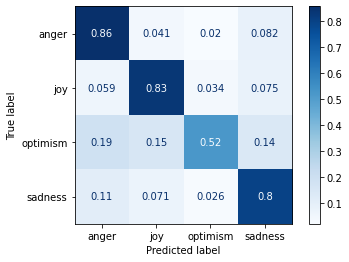

In [24]:
cm = confusion_matrix(ds_validation["label"], pred_labels, normalize="true")
disp = ConfusionMatrixDisplay(cm, display_labels=ds_validation.features["label"].names)
disp.plot(cmap="Blues")

**Again here the problem is the "optimism" category.**

One of the reasons could be the size of the related dataset.

## Finding Top N

In [25]:
import torch.nn.functional as F

In [26]:
ds_validation.set_format("torch")
pred_labels = preds.logits.argmax(1).cpu()
losss = F.cross_entropy(preds.logits.cpu(), ds_validation["label"].cpu(), reduction="none")

In [27]:
ds_validation.set_format("pandas")
df_valid = ds_validation[:][["text", "label"]]
df_valid["label"] = ds_validation.features["label"].int2str(df_valid["label"])
df_valid["pred_label"] = ds_validation.features["label"].int2str(pred_labels)
df_valid["loss"] = losss
df_valid.head()

,text,label,pred_label,loss
0,#Deppression is real. Partners w/ #depressed p...,sadness,sadness,0.078499
1,@user Interesting choice of words... Are you c...,anger,anger,0.137514
2,My visit to hospital for care triggered #traum...,sadness,sadness,0.061973
3,@user Welcome to #MPSVT! We are delighted to h...,joy,joy,0.174798
4,What makes you feel #joyful?,joy,joy,0.122839


### Top Loosers

In [28]:
df_valid.sort_values("loss", ascending=False).head(10)

,text,label,pred_label,loss
581,13) mutual whos always online - @user bc we ha...,joy,anger,4.917319
1041,@user Thing is tho my pout was actually serious,optimism,anger,4.805089
117,The patients were increasingly protected durin...,joy,anger,4.615057
424,Every time I fart my dog jumps in fear hahahah...,joy,anger,4.534210
735,@user 3. home alone 4. fast and furious,joy,anger,4.491758
1344,mom asked if i wanted acrylics &amp; i said 'n...,sadness,anger,4.386020
213,#Sleep is my #drug. My bed is my dealer. My #a...,joy,anger,4.361046
1084,@user 😂😂 i love ur angry comments,joy,anger,4.220979
775,"@user 'call to action by TV host John Oliver, ...",sadness,anger,4.205841
1031,When you get paid and you instantly start buyi...,sadness,anger,4.156839


### Top Winners

In [29]:
df_valid.sort_values("loss", ascending=True).head(10)

,text,label,pred_label,loss
65,"Aw, bummer. @user (Maura Rankin) blocked me fo...",anger,anger,0.024534
354,Paul is such a fucking bully! Dam leave the po...,anger,anger,0.026424
1021,@user @user Trump is now fuming. He feels the...,anger,anger,0.026675
233,#YummyMummiesAU Are you serious! Breastfeeding...,anger,anger,0.026773
67,"Gorkas is angrily unhinged, &amp;lecturing CNN...",anger,anger,0.026826
202,"we will send video to proper agency ,state wor...",anger,anger,0.026832
911,KEEF\n \n #annoyed! cant make me bursting out ...,anger,anger,0.026920
603,@user Stupid cunt is relentless with his bullshit,anger,anger,0.027028
824,@user Horrible CNN interview. U can't talk ur...,anger,anger,0.027047
1348,they think they're The Shit when they ain't sh...,anger,anger,0.027098
